## Código

#### Versão 1

In [1]:
import numpy as np
import random
import os
from deap import base, creator, tools, algorithms

# Configurações do algoritmo genético
pop_size = 500 
num_generations = 20000
mutation_rate = 0.3 
crossover_rate = 0.8

# Limites dos parâmetros
Nblades_range = [2, 6]
chord_range = [0.1, 1.0]
beta_range = [0.0, 35.0]

# Variáveis globais para os valores fixos e iniciais
r_fixed = []
chord_initial = []
beta_initial = []
header_lines = []

# Função para ler o arquivo de hélice
def read_propeller_file(file_path):
    global r_fixed, chord_initial, beta_initial, header_lines
    r_fixed = []
    chord_initial = []
    beta_initial = []
    header_lines = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extrair o cabeçalho
    start_index = 0
    for i, line in enumerate(lines):
        header_lines.append(line)
        if line.strip().startswith('#'):
            start_index = i
            break

    # Extrair os valores de r, chord e beta
    for line in lines[start_index + 1:]:
        if line.strip() == '' or line.strip().startswith('#'):
            continue
        values = line.split()
        if len(values) >= 3:
            r_fixed.append(float(values[0]))
            chord_initial.append(float(values[1]))
            beta_initial.append(float(values[2]))

# Configuração do DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Funções de inicialização
def init_individual():
    Nblades = random.randint(Nblades_range[0], Nblades_range[1])
    chord = [random.uniform(chord_range[0], chord_range[1]) for _ in range(len(r_fixed))]
    beta = [random.uniform(beta_range[0], beta_range[1]) for _ in range(len(r_fixed))]
    return creator.Individual([Nblades, chord, beta])

toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Função de avaliação
def evaluate(individual):
    Nblades, chord, beta = individual

    # Crie o arquivo de input para QPROP
    with open('temp_propeller.txt', 'w') as f:
        # Escreve o cabeçalho e substitui a linha do número de pás
        for line in header_lines:
            if '! Nblades' in line:
                # Substitui a linha do número de pás
                f.write(f' {Nblades}           ! Nblades\n')
            else:
                f.write(line)
        
        # Adicione a seção de r, chord e beta (muito importante)
        f.write('#  r    chord    beta\n')
        for i in range(len(r_fixed)):
            f.write(f'{r_fixed[i]:.7f}\t{chord[i]:.7f}\t{beta[i]:.7f}\n')

    # Execute o QPROP 
    os.system('qprop temp_propeller.txt inputFiles/propdrivev2.txt inputFiles/solar1run.txt > results_temp.txt')
    
    # Leia a saída do QPROP - obtem a eficiência propulsiva 
    try:
        with open('results_temp.txt', 'r') as result_file:
            output_lines = result_file.readlines()
            # Extrair os valores da coluna 'effprop' (10ª coluna) a partir da linha 18
            efficiency_values = []
            for line in output_lines[17:]:
                values = line.split()
                if len(values) >= 10:
                    try:
                        efficiency_values.append(float(values[9]))  # 10ª coluna, índice 9
                    except ValueError:
                        # Ignorar linhas que não contêm valores numéricos válidos
                        continue
            
            # Calcula a média das eficiências
            efficiency = np.mean(efficiency_values) if efficiency_values else 0

            # Aplicar penalidade se a eficiência estiver fora do intervalo [0, 1]
            if efficiency < 0 or efficiency > 1:
                efficiency = 0  # Penalidade
    except Exception as e:
        print(f"Erro ao ler a saída do QPROP: {e}")
        efficiency = 0  # Defina um valor padrão ou tome outra ação apropriada
    
    return (efficiency,)

toolbox.register("evaluate", evaluate)

# Funções de seleção, cruzamento e mutação
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)

# Função de mutação personalizada
def mutate_individual(individual):
    Nblades, chord, beta = individual
    if random.random() < mutation_rate:
        Nblades = random.randint(Nblades_range[0], Nblades_range[1])
    if random.random() < mutation_rate:
        chord = [random.uniform(chord_range[0], chord_range[1]) for _ in range(len(r_fixed))]
    if random.random() < mutation_rate:
        beta = [random.uniform(max(beta_range[0], beta_range[1] - i * (beta_range[1] / (len(r_fixed) - 1))), beta_range[1]) for i in range(len(r_fixed))]
    individual[:] = [Nblades, chord, beta]
    return individual,

toolbox.register("mutate", mutate_individual)

# Função principal do algoritmo genético
def genetic_algorithm():
    population = toolbox.population(n=pop_size)
    for generation in range(num_generations):
        # Elitismo: Mantenha os melhores indivíduos
        elite = tools.selBest(population, k=1)
        
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
        fits = list(map(toolbox.evaluate, offspring))

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Seleção com inclusão da elite
        population = toolbox.select(offspring + elite, k=len(population))
        best_individual = tools.selBest(population, k=1)[0]
        print(f'Generation {generation}: Best Fitness = {best_individual.fitness.values[0]}')
    
    best_individual = tools.selBest(population, k=1)[0]
    Nblades, chord, beta = best_individual
    # Salvar o melhor indivíduo
    with open('best_propeller.txt', 'w') as f:
        # Escreva o cabeçalho e substitua a linha do número de pás
        for line in header_lines:
            if '! Nblades' in line:
                f.write(f' {Nblades}           ! Nblades\n')
            else:
                f.write(line)
        f.write('#  r    chord    beta\n')
        for i in range(len(r_fixed)):
            f.write(f'{r_fixed[i]:.7f}\t{chord[i]:.7f}\t{beta[i]:.7f}\n')
    print('O melhor indivíduo foi salvo em "best_propeller.txt".')

# Função para carregar o arquivo de hélice e executar o algoritmo genético
def optimize_propeller(file_path):
    read_propeller_file(file_path)
    genetic_algorithm()

# Exemplo de uso
optimize_propeller('inputFiles/APC12x6.txt')

Generation 0: Best Fitness = 0.49654516129032256
Generation 1: Best Fitness = 0.4986290322580645
Generation 2: Best Fitness = 0.5051903225806452
Generation 3: Best Fitness = 0.5054967741935484
Generation 4: Best Fitness = 0.5096935483870968
Generation 5: Best Fitness = 0.5115935483870968
Generation 6: Best Fitness = 0.5258516129032258
Generation 7: Best Fitness = 0.5298354838709679
Generation 8: Best Fitness = 0.5298354838709679
Generation 9: Best Fitness = 0.5298354838709679
Generation 10: Best Fitness = 0.5298354838709679
Generation 11: Best Fitness = 0.5298354838709679
Generation 12: Best Fitness = 0.5298354838709679
Generation 13: Best Fitness = 0.5298354838709679
Generation 14: Best Fitness = 0.5298354838709679
Generation 15: Best Fitness = 0.5298354838709679
Generation 16: Best Fitness = 0.5298354838709679
Generation 17: Best Fitness = 0.5298354838709679
Generation 18: Best Fitness = 0.5298354838709679
Generation 19: Best Fitness = 0.5298354838709679
Generation 20: Best Fitness =

KeyboardInterrupt: 

### Versão 2

In [ ]:
import numpy as np
import random
import os
from deap import base, creator, tools, algorithms

# Configurações do algoritmo genético
pop_size = 500 
num_generations = 20000
mutation_rate = 0.3 
crossover_rate = 0.8

# Limites dos parâmetros
Nblades_range = [2, 6]
chord_range = [0.1, 1.0]
beta_range = [0.0, 35.0]

# Variáveis globais para os valores fixos e iniciais
r_fixed = []
chord_initial = []
beta_initial = []
header_lines = []

# Função para ler o arquivo de hélice
def read_propeller_file(file_path):
    global r_fixed, chord_initial, beta_initial, header_lines
    r_fixed = []
    chord_initial = []
    beta_initial = []
    header_lines = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extrair o cabeçalho
    start_index = 0
    for i, line in enumerate(lines):
        header_lines.append(line)
        if line.strip().startswith('#'):
            start_index = i
            break

    # Extrair os valores de r, chord e beta
    for line in lines[start_index + 1:]:
        if line.strip() == '' or line.strip().startswith('#'):
            continue
        values = line.split()
        if len(values) >= 3:
            r_fixed.append(float(values[0]))
            chord_initial.append(float(values[1]))
            beta_initial.append(float(values[2]))

# Configuração do DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Funções de inicialização
def init_individual():
    Nblades = random.randint(Nblades_range[0], Nblades_range[1])
    chord = [random.uniform(chord_range[0], chord_range[1]) for _ in range(len(r_fixed))]
    beta = [random.uniform(beta_range[0], beta_range[1]) for _ in range(len(r_fixed))]
    return creator.Individual([Nblades, chord, beta])

toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Função de avaliação
def evaluate(individual):
    Nblades, chord, beta = individual

    # Crie o arquivo de input para QPROP
    with open('temp_propeller.txt', 'w') as f:
        # Remover linhas duplicadas do cabeçalho
        seen_lines = set()
        for line in header_lines:
            if line not in seen_lines:
                if '! Nblades' in line:
                    # Substitui a linha do número de pás
                    f.write(f' {Nblades}           ! Nblades\n')
                elif '#  r    chord    beta' in line:
                    # Ignore a linha duplicada no cabeçalho
                    continue
                else:
                    f.write(line)
                seen_lines.add(line)
        
        # Adicione a seção de r, chord e beta (muito importante)
        f.write('#  r    chord    beta\n')
        for i in range(len(r_fixed)):
            f.write(f'{r_fixed[i]:.7f}\t{chord[i]:.7f}\t{beta[i]:.7f}\n')

    # Execute o QPROP 
    os.system('qprop temp_propeller.txt inputFiles/propdrivev2.txt inputFiles/solar1run.txt > results_temp.txt')
    
    # Leia a saída do QPROP - obtem a eficiência propulsiva 
    try:
        with open('results_temp.txt', 'r') as result_file:
            output_lines = result_file.readlines()
            # Extrair os valores da coluna 'effprop' (10ª coluna) a partir da linha 18
            efficiency_values = []
            for line in output_lines[17:]:
                values = line.split()
                if len(values) >= 10:
                    try:
                        efficiency_values.append(float(values[9]))  # 10ª coluna, índice 9
                    except ValueError:
                        # Ignorar linhas que não contêm valores numéricos válidos
                        continue
            
            # Calcula a média das eficiências
            efficiency = np.mean(efficiency_values) if efficiency_values else 0

            # Aplicar penalidade se a eficiência estiver fora do intervalo [0, 1]
            if efficiency < 0 or efficiency > 1:
                efficiency = 0  # Penalidade
    except Exception as e:
        print(f"Erro ao ler a saída do QPROP: {e}")
        efficiency = 0  # Defina um valor padrão ou tome outra ação apropriada
    
    return (efficiency,)

toolbox.register("evaluate", evaluate)

# Funções de seleção, cruzamento e mutação
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)

# Função de mutação personalizada
def mutate_individual(individual):
    Nblades, chord, beta = individual
    if random.random() < mutation_rate:
        Nblades = random.randint(Nblades_range[0], Nblades_range[1])
    if random.random() < mutation_rate:
        chord = [random.uniform(chord_range[0], chord_range[1]) for _ in range(len(r_fixed))]
    if random.random() < mutation_rate:
        beta = [random.uniform(max(beta_range[0], beta_range[1] - i * (beta_range[1] / (len(r_fixed) - 1))), beta_range[1]) for i in range(len(r_fixed))]
    individual[:] = [Nblades, chord, beta]
    return individual,

toolbox.register("mutate", mutate_individual)

# Função principal do algoritmo genético
def genetic_algorithm():
    population = toolbox.population(n=pop_size)
    for generation in range(num_generations):
        # Elitismo: Mantenha os melhores indivíduos
        elite = tools.selBest(population, k=1)
        
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
        fits = list(map(toolbox.evaluate, offspring))

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Seleção com inclusão da elite
        population = toolbox.select(offspring + elite, k=len(population))
        best_individual = tools.selBest(population, k=1)[0]
        print(f'Generation {generation}: Best Fitness = {best_individual.fitness.values[0]}')
    
    best_individual = tools.selBest(population, k=1)[0]
    Nblades, chord, beta = best_individual
    # Salvar o melhor indivíduo
    with open('best_propeller.txt', 'w') as f:
        # Escreva o cabeçalho e substitua a linha do número de pás
        for line in header_lines:
            if '! Nblades' in line:
                f.write(f' {Nblades}           ! Nblades\n')
            elif '#  r    chord    beta' in line:
                continue  # Ignore the duplicate line
            else:
                f.write(line)
        f.write('#  r    chord    beta\n')
        for i in range(len(r_fixed)):
            f.write(f'{r_fixed[i]:.7f}\t{chord[i]:.7f}\t{beta[i]:.7f}\n')
    print('O melhor indivíduo foi salvo em "best_propeller.txt".')

# Função para carregar o arquivo de hélice e executar o algoritmo genético
def optimize_propeller(file_path):
    read_propeller_file(file_path)
    genetic_algorithm()

# Exemplo de uso
optimize_propeller('inputFiles/APC12x6.txt')

### Versão 3 - Mais atualizada e coerente{}

In [16]:
import numpy as np
import random
import os
from deap import base, creator, tools, algorithms

# Configurações do algoritmo genético
pop_size = 10 
num_generations = 100
mutation_rate = 0.3 
crossover_rate = 0.8

# Limites dos parâmetros
Nblades_range = [2, 6]
chord_range = [0.1, 1.0]
beta_range = [0.0, 45.0]

# Variáveis globais para os valores fixos e iniciais
r_fixed = []
chord_initial = []
beta_initial = []
header_lines = []

# Função para ler o arquivo de hélice
def read_propeller_file(file_path):
    global r_fixed, chord_initial, beta_initial, header_lines
    r_fixed = []
    chord_initial = []
    beta_initial = []
    header_lines = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extrair o cabeçalho
    start_index = 0
    for i, line in enumerate(lines):
        header_lines.append(line)
        if line.strip().startswith('#'):
            start_index = i
            break

    # Extrair os valores de r, chord e beta
    for line in lines[start_index + 1:]:
        if line.strip() == '' or line.strip().startswith('#'):
            continue
        values = line.split()
        if len(values) >= 3:
            r_fixed.append(float(values[0]))
            chord_initial.append(float(values[1]))
            beta_initial.append(float(values[2]))

# Configuração do DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Funções de inicialização
def init_individual():
    Nblades = random.randint(Nblades_range[0], Nblades_range[1])
    chord = [random.uniform(chord_range[0], chord_range[1]) for _ in range(len(r_fixed))]
    beta = [random.uniform(beta_range[0], beta_range[1]) for _ in range(len(r_fixed))]
    return creator.Individual([Nblades, chord, beta])

toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Função de avaliação
def evaluate(individual):
    Nblades, chord, beta = individual

    # Crie o arquivo de input para QPROP
    with open('temp_propeller.txt', 'w') as f:
        # Escreva o cabeçalho e substitua a linha do número de pás
        for line in header_lines:
            if '! Nblades' in line:
                f.write(f' {Nblades}           ! Nblades\n')
            elif '#  r    chord    beta' in line:
                continue  # Ignore the duplicate line
            else:
                f.write(line)
        f.write('\n')  # Adiciona uma linha em branco para espaçamento
        f.write('#  r    chord    beta\n')
        for i in range(len(r_fixed)):
            f.write(f'{r_fixed[i]:.7f}\t{chord[i]:.7f}\t{beta[i]:.7f}\n')

    # Execute o QPROP 
    os.system('qprop temp_propeller.txt inputFiles/propdrivev2.txt inputFiles/solar1run.txt > results_temp.txt')
    
    # Leia a saída do QPROP - obtem a eficiência propulsiva 
    try:
        with open('results_temp.txt', 'r') as result_file:
            output_lines = result_file.readlines()
            # Extrair os valores da coluna 'effprop' (10ª coluna) a partir da linha 18
            efficiency_values = []
            for line in output_lines[17:]:
                values = line.split()
                if len(values) >= 10:
                    try:
                        efficiency_values.append(float(values[9]))  # 10ª coluna, índice 9
                    except ValueError:
                        # Ignorar linhas que não contêm valores numéricos válidos
                        continue
            
            # Calcula a média das eficiências
            efficiency = np.mean(efficiency_values) if efficiency_values else 0

            # Aplicar penalidade se a eficiência estiver fora do intervalo [0, 1]
            if efficiency < 0 or efficiency > 1:
                efficiency = 0  # Penalidade
    except Exception as e:
        print(f"Erro ao ler a saída do QPROP: {e}")
        efficiency = 0  # Defina um valor padrão ou tome outra ação apropriada
    
    return (efficiency,)

toolbox.register("evaluate", evaluate)

# Funções de seleção, cruzamento e mutação
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)

# Função de mutação personalizada
def mutate_individual(individual):
    Nblades, chord, beta = individual
    if random.random() < mutation_rate:
        Nblades = random.randint(Nblades_range[0], Nblades_range[1])
    if random.random() < mutation_rate:
        chord = [random.uniform(chord_range[0], chord_range[1]) for _ in range(len(r_fixed))]
    if random.random() < mutation_rate:
        beta = [random.uniform(max(beta_range[0], beta_range[1] - i * (beta_range[1] / (len(r_fixed) - 1))), beta_range[1]) for i in range(len(r_fixed))]
    individual[:] = [Nblades, chord, beta]
    return individual,

toolbox.register("mutate", mutate_individual)

# Função principal do algoritmo genético
def genetic_algorithm():
    population = toolbox.population(n=pop_size)
    for generation in range(num_generations):
        # Elitismo: Mantenha os melhores indivíduos
        elite = tools.selBest(population, k=1)
        
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
        fits = list(map(toolbox.evaluate, offspring))

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Seleção com inclusão da elite
        population = toolbox.select(offspring + elite, k=len(population))
        best_individual = tools.selBest(population, k=1)[0]
        print(f'Generation {generation}: Best Fitness = {best_individual.fitness.values[0]}')
    
    best_individual = tools.selBest(population, k=1)[0]
    Nblades, chord, beta = best_individual
    # Salvar o melhor indivíduo
    with open('best_propeller.txt', 'w') as f:
        # Escreva o cabeçalho e substitua a linha do número de pás
        for line in header_lines:
            if '! Nblades' in line:
                f.write(f' {Nblades}           ! Nblades\n')
            elif '#  r    chord    beta' in line:
                continue  # Ignore the duplicate line
            else:
                f.write(line)
        f.write('#  r    chord    beta\n')
        for i in range(len(r_fixed)):
            f.write(f'{r_fixed[i]:.7f}\t{chord[i]:.7f}\t{beta[i]:.7f}\n')
    print('O melhor indivíduo foi salvo em "best_propeller.txt".')

# Função para carregar o arquivo de hélice e executar o algoritmo genético
def optimize_propeller(file_path):
    read_propeller_file(file_path)
    genetic_algorithm()

# Exemplo de uso
optimize_propeller('inputFiles/APC12x6.txt')

Generation 0: Best Fitness = 0.4327354838709678
Generation 1: Best Fitness = 0.4492451612903226
Generation 2: Best Fitness = 0.4511354838709678
Generation 3: Best Fitness = 0.4575516129032258
Generation 4: Best Fitness = 0.46009032258064525
Generation 5: Best Fitness = 0.46009032258064525
Generation 6: Best Fitness = 0.46009032258064525
Generation 7: Best Fitness = 0.46009032258064525
Generation 8: Best Fitness = 0.46009032258064525
Generation 9: Best Fitness = 0.46009032258064525
Generation 10: Best Fitness = 0.46009032258064525
Generation 11: Best Fitness = 0.46009032258064525
Generation 12: Best Fitness = 0.46009032258064525
Generation 13: Best Fitness = 0.46009032258064525
Generation 14: Best Fitness = 0.46009032258064525
Generation 15: Best Fitness = 0.46009032258064525
Generation 16: Best Fitness = 0.46050645161290327
Generation 17: Best Fitness = 0.46050645161290327
Generation 18: Best Fitness = 0.46050645161290327
Generation 19: Best Fitness = 0.46050645161290327
Generation 20:

## Análise gráfica

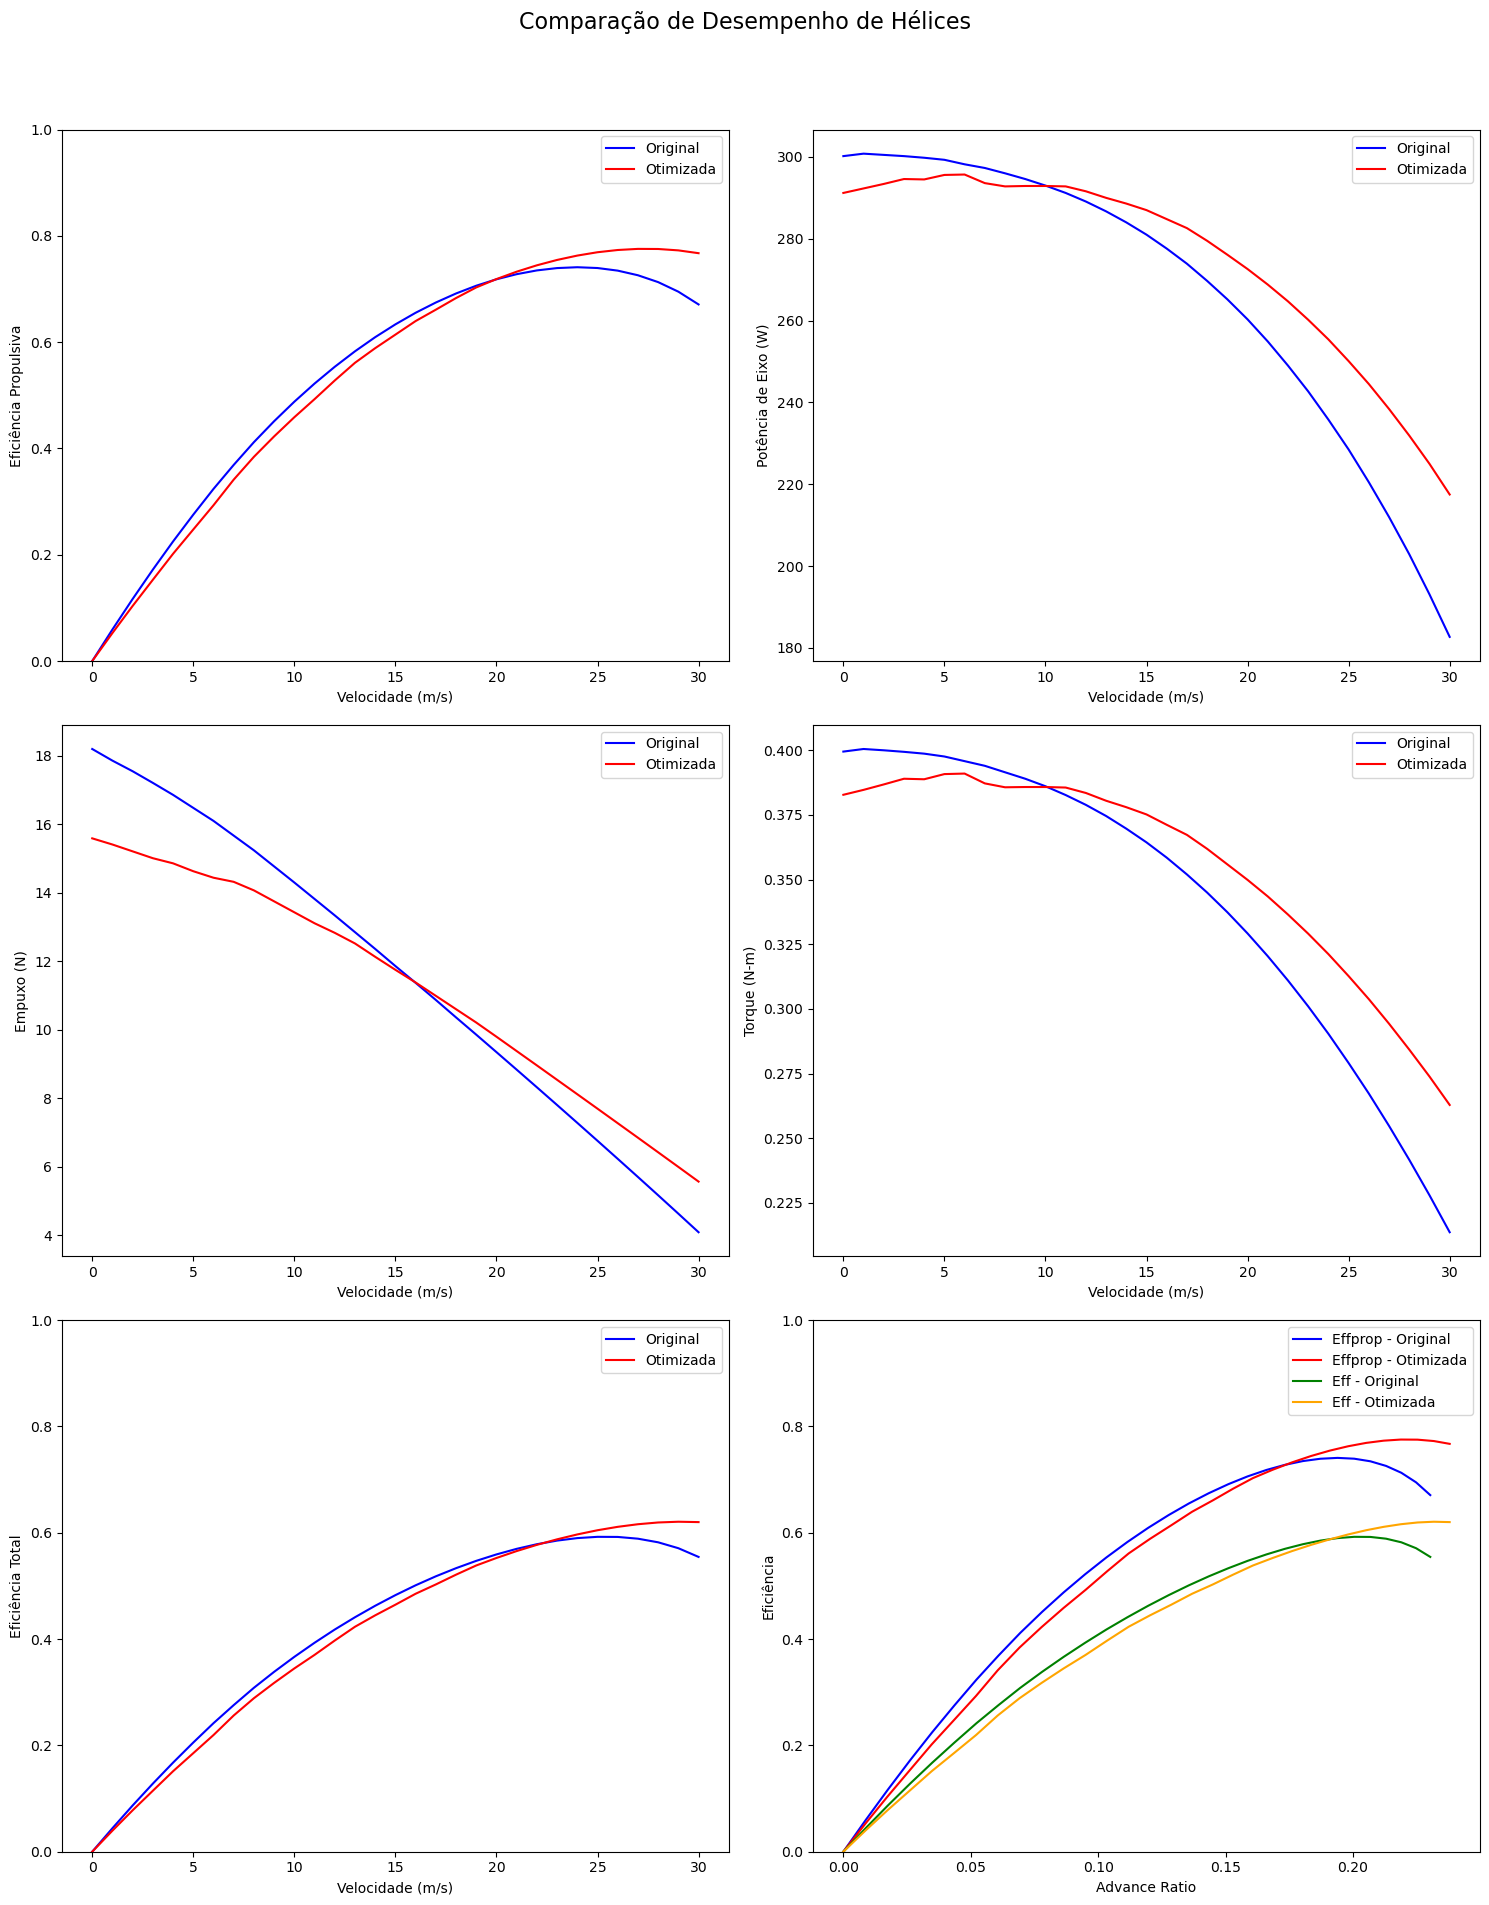

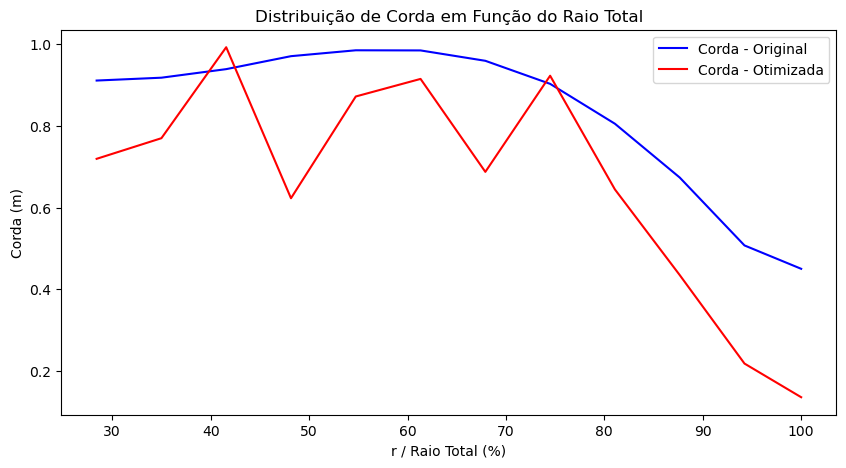

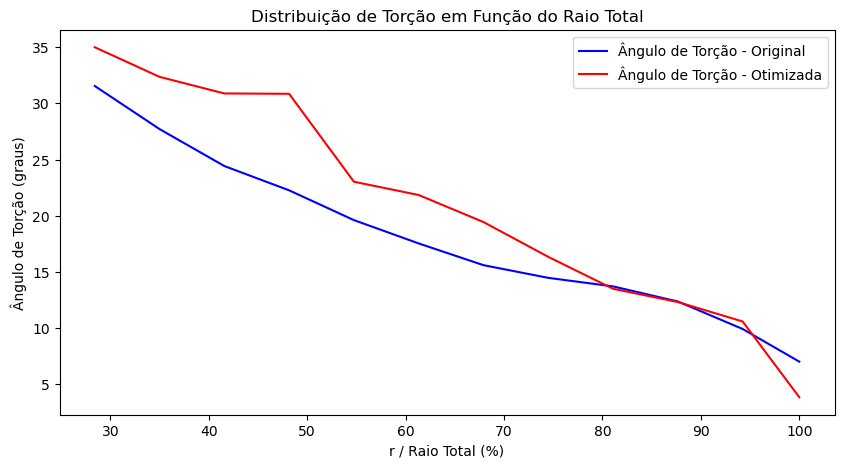

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def parse_helice(file_path):
    data = {'r': [], 'chord': [], 'beta': []}
    with open(file_path, 'r') as file:
        lines = file.readlines()[15:]  # Pular as 15 primeiras linhas
        for line in lines:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                if len(parts) == 3:
                    try:
                        r, chord, beta = map(float, parts)
                        data['r'].append(r)
                        data['chord'].append(chord)
                        data['beta'].append(beta)
                    except ValueError:
                        continue  # Ignorar linhas que não possam ser convertidas
    return data

def parse_resultados(file_path):
    data = {'V': [], 'effprop': [], 'Pshaft': [], 'T': [], 'Q': [], 'eff': [], 'advance_ratio': []}
    with open(file_path, 'r') as file:
        lines = file.readlines()[17:]  # Pular as 17 primeiras linhas
        for line in lines:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                if len(parts) >= 19:
                    try:
                        V = float(parts[0])  # Velocidade está na primeira coluna
                        effprop = float(parts[9])  # Eficiência Propulsiva (index 9)
                        Pshaft = float(parts[5])  # Potência de Eixo
                        T = float(parts[3])  # Empuxo (index 2)
                        Q = float(parts[4])  # Torque (index 3)
                        eff = float(parts[14])  # Eficiência Total (index 14)
                        advance_ratio = float(parts[10])  # Advance Ratio (index 10)
                        # Garantir que a eficiência esteja entre 0 e 1
                        effprop = max(0, min(1, effprop))
                        eff = max(0, min(1, eff))
                        data['V'].append(V)
                        data['effprop'].append(effprop)
                        data['Pshaft'].append(Pshaft)
                        data['T'].append(T)
                        data['Q'].append(Q)
                        data['eff'].append(eff)
                        data['advance_ratio'].append(advance_ratio)
                    except ValueError:
                        continue  # Ignorar linhas que não possam ser convertidas
    return data

def plot_graphs(helice_data_original, helice_data_otimizada, resultados_data_original, resultados_data_otimizada):
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))
    fig.suptitle('Comparação de Desempenho de Hélices', fontsize=16)

    # Comparação de Eficiência Propulsiva vs. Velocidade
    axs[0, 0].plot(resultados_data_original['V'], resultados_data_original['effprop'], label='Original', color='blue')
    axs[0, 0].plot(resultados_data_otimizada['V'], resultados_data_otimizada['effprop'], label='Otimizada', color='red')
    axs[0, 0].set_xlabel('Velocidade (m/s)')
    axs[0, 0].set_ylabel('Eficiência Propulsiva')
    axs[0, 0].set_ylim(0, 1)
    axs[0, 0].legend()

    # Comparação de Potência de Eixo vs. Velocidade
    axs[0, 1].plot(resultados_data_original['V'], resultados_data_original['Pshaft'], label='Original', color='blue')
    axs[0, 1].plot(resultados_data_otimizada['V'], resultados_data_otimizada['Pshaft'], label='Otimizada', color='red')
    axs[0, 1].set_xlabel('Velocidade (m/s)')
    axs[0, 1].set_ylabel('Potência de Eixo (W)')
    axs[0, 1].legend()

    # Comparação de Empuxo vs. Velocidade
    axs[1, 0].plot(resultados_data_original['V'], resultados_data_original['T'], label='Original', color='blue')
    axs[1, 0].plot(resultados_data_otimizada['V'], resultados_data_otimizada['T'], label='Otimizada', color='red')
    axs[1, 0].set_xlabel('Velocidade (m/s)')
    axs[1, 0].set_ylabel('Empuxo (N)')
    axs[1, 0].legend()

    # Comparação de Torque vs. Velocidade
    axs[1, 1].plot(resultados_data_original['V'], resultados_data_original['Q'], label='Original', color='blue')
    axs[1, 1].plot(resultados_data_otimizada['V'], resultados_data_otimizada['Q'], label='Otimizada', color='red')
    axs[1, 1].set_xlabel('Velocidade (m/s)')
    axs[1, 1].set_ylabel('Torque (N-m)')
    axs[1, 1].legend()

    # Comparação de Eficiência Total vs. Velocidade
    axs[2, 0].plot(resultados_data_original['V'], resultados_data_original['eff'], label='Original', color='blue')
    axs[2, 0].plot(resultados_data_otimizada['V'], resultados_data_otimizada['eff'], label='Otimizada', color='red')
    axs[2, 0].set_xlabel('Velocidade (m/s)')
    axs[2, 0].set_ylabel('Eficiência Total')
    axs[2, 0].set_ylim(0, 1)
    axs[2, 0].legend()

    # Comparação de Eficiência Propulsiva e Eficiência Total vs. Advance Ratio
    axs[2, 1].plot(resultados_data_original['advance_ratio'], resultados_data_original['effprop'], label='Effprop - Original', color='blue')
    axs[2, 1].plot(resultados_data_otimizada['advance_ratio'], resultados_data_otimizada['effprop'], label='Effprop - Otimizada', color='red')
    axs[2, 1].plot(resultados_data_original['advance_ratio'], resultados_data_original['eff'], label='Eff - Original', color='green')
    axs[2, 1].plot(resultados_data_otimizada['advance_ratio'], resultados_data_otimizada['eff'], label='Eff - Otimizada', color='orange')
    axs[2, 1].set_xlabel('Advance Ratio')
    axs[2, 1].set_ylabel('Eficiência')
    axs[2, 1].set_ylim(0, 1)
    axs[2, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Gráfico separado para distribuição de corda
    plt.figure(figsize=(10, 5))
    plt.plot(np.array(helice_data_original['r']) / helice_data_original['r'][-1] * 100, helice_data_original['chord'], label='Corda - Original', color='blue')
    plt.plot(np.array(helice_data_otimizada['r']) / helice_data_otimizada['r'][-1] * 100, helice_data_otimizada['chord'], label='Corda - Otimizada', color='red')
    plt.xlabel('r / Raio Total (%)')
    plt.ylabel('Corda (m)')
    plt.legend()
    plt.title('Distribuição de Corda em Função do Raio Total')
    plt.show()

    # Gráfico separado para distribuição de torção
    plt.figure(figsize=(10, 5))
    plt.plot(np.array(helice_data_original['r']) / helice_data_original['r'][-1] * 100, helice_data_original['beta'], label='Ângulo de Torção - Original', color='blue')
    plt.plot(np.array(helice_data_otimizada['r']) / helice_data_otimizada['r'][-1] * 100, helice_data_otimizada['beta'], label='Ângulo de Torção - Otimizada', color='red')
    plt.xlabel('r / Raio Total (%)')
    plt.ylabel('Ângulo de Torção (graus)')
    plt.legend()
    plt.title('Distribuição de Torção em Função do Raio Total')
    plt.show()

# Caminhos dos arquivos
helice_original_path = 'inputFiles/APC12x6.txt'
helice_otimizada_path = 'temp_propeller.txt'
resultados_original_path = 'inputFiles/results12x6PY.txt'
resultados_otimizada_path = 'results_temp.txt'

# Extração dos dados
helice_data_original = parse_helice(helice_original_path)
helice_data_otimizada = parse_helice(helice_otimizada_path)
resultados_data_original = parse_resultados(resultados_original_path)
resultados_data_otimizada = parse_resultados(resultados_otimizada_path)

# Plotagem dos gráficos
plot_graphs(helice_data_original, helice_data_otimizada, resultados_data_original, resultados_data_otimizada)


## Plotagem das hélices